# New Capstone submission

## Capstone Project Proposal

Government initiatives should maintain a solid connection to research and data that supports decision making. With the proper data to support decision, government entities can act with some confidence to achieve positive results from its policy implementations. Using Machine learning I would like to offer a road map for decision makers by connecting research papers and their conclusions to data as cited in their research documentation.   Using NLP machine learning techniques I want to scan documents for relevant citations which support the predictions contained in the conclusions of the research document. We can then use this to inform decisions. True or False? Do the conclusions in research docments pro

This project is derived from a Kaggle competition proposed by the Coleridge Initiative entitled “Show US the Data”.  The competition challenges data scientists to use machine learning to “find the hidden-in-plain-sight data citations”. The initiative seeks to restore confidence in in evidenced based research  so that governments can provide transparency and validation  for the reasons for policy decisions. 

The data sets that I have gathered to train and test my algorithm are directly from the kaggle competition. They consist of three files containing url links, document abstracts,  and complete research documents. The data is mostly clean but will need to be explored for inconsistencies and missing data.

Using NLP I will seek to gather evidence of research data and connect the data to conclusions reached in the research papers. I envision that my algorithm will categorize language first as asserting a conclusion.  Then connect those conclusions with data citations.  Each conclusion may have a corresponding citation and a statistic. 



## Import necessary modules.

In [1]:
import pandas as pd
import numpy as np
import time as tm
import matplotlib.pyplot as plt
import json as js
import boto3
import nltk

%matplotlib inline

## Load data

To start with we import publications and papers. To fill out the data we may include more documents gathered from arxiv.

In [2]:
papers = pd.read_csv('../../papers.csv')
publications = pd.read_csv('../../publications.csv')
arxivData = js.load(open('../../arxivData.json'))

In [3]:
ar_pub_id=publications.groupby('pub_id').count().reset_index().iloc[:,0].values

In [4]:
papers['journal'][0:2].values

array(['medRxiv : the preprint server for health sciences',
       'International journal of surgery protocols'], dtype=object)

In [5]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121803 entries, 0 to 121802
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   pmid            121803 non-null  int64 
 1   doi             118305 non-null  object
 2   journal         121062 non-null  object
 3   country         120458 non-null  object
 4   title           121062 non-null  object
 5   authors         120266 non-null  object
 6   abstract        121062 non-null  object
 7   citation_count  121803 non-null  int64 
 8   published_at    121062 non-null  object
dtypes: int64(2), object(7)
memory usage: 8.4+ MB


In [6]:
def get_text(p_id):
    doc = publications[ publications['pub_id'] == p_id][['text']]
    doc.dropna(inplace=True)
    txtdoc = ' '.join(doc['text'].values)
    return txtdoc

pid_text_list = []

for pub_id in ar_pub_id:
    pid_text_list.append({'id':pub_id,'text':get_text(pub_id)})

In [7]:
df_pid_text = pd.DataFrame(pid_text_list)

In [8]:
df_pid_text.sort_values(by='text', ascending=False)

,id,text
2076,25a28250-4ee3-47b6-9e60-63473915cd0d, We present a robust and simple bias-adjustme...
7080,7f04db21-3db5-4e7d-8dfe-2263a0cbd016, The visual identification of atrophy is most...
1125,1394926d-b037-4e76-a57d-ed0e94c09de1, The study is run on 756 aMCI subjects from t...
11698,d150ed29-d83e-4ce4-bce4-ebfc58272190," The hippocampus, the sagittal stratum, the c..."
8397,96b5a196-b937-4be3-b775-5c06a8fae68c, Multi-class classification of normal control...
...,...,...
7470,85de886e-eb37-4402-b219-386686cfc493,\n The U.S. TIMSS Advanced 1995 &2015 Technica...
669,0af2cf77-6a17-41a6-a07a-d104d79ba245,\n\n Part I: Where are we and how did we get h...
10259,b891ad0d-9ba8-4cba-8045-e1b9df990215,\n\n BUILT ENVIRONMENT VOL 43 NO 3 may have th...
9152,a475d47e-3fe5-43c5-ab2d-fbd1bfd38769,\n\n\nMarketing contracts are common for speci...


I would like to get a sense of what words are most common in the corpus and what words may convey depedence on cited data.

In [9]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def get_language(text):
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-2')
    dominant_lang_js = js.dumps(comprehend.detect_dominant_language(Text=text), sort_keys=True,indent=4)
    return dominant_lang_js
    
round1 = lambda x: clean_text_round1(x)

In [10]:
df_pid_text_clean = pd.DataFrame(df_pid_text.text.apply(round1))
df_pid_text_clean

,text
0,the aim of this study was to identify if acqui...
1,in this study finnish ninth graders and their ...
2,through the us department of agricultures econ...
3,risk factors and cognitive sequelae of brain a...
4,potential conflicts of interest the author has...
...,...
14311,waterquality data for nitrate fecalindicator b...
14312,magnetic resonance imaging mri is of fundament...
14313,the pandemic and the fear that it has brought...
14314,mathematics as no other school subject evokes ...


So to get an idea of word usage I will create a Document term matrix Using the CountVectorizer in sci-kitlearn. 

In [11]:
#from nltk.tokenize import sent_tokenize
#from io import StringIO
#def get_lang(text):
#    text_par = df_pid_text['text'][0]
#    text_sent = sent_tokenize(text_par)
#    comprehend = boto3.client(service_name='comprehend', region_name='us-east-2')
    #dominant_lang_js = js.dumps(comprehend.detect_dominant_language(Text=text_sent[0]), sort_keys=True)
    #io_dominant_lang_js = StringIO
#    dominant_lang_js = comprehend.detect_dominant_language(Text=text_sent[0])
#    return dominant_lang_js['Languages'][0]['LanguageCode']


In [13]:
#df_pid_text['language'] = df_pid_text.text.apply(get_lang)
#df_pid_text = pd.read_csv('df_pid_text.csv')

In [12]:
#df_pid_text[df_pid_text['language'] == 'en']

In [13]:
text_list_of_docs = list(df_pid_text_clean.text.values)
len(text_list_of_docs)

14316

In [14]:
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS
#from nltk.corpus import stopwords

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(articles,self):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]




stopwords_org=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 
           'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
           'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is',
           's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 
           'we', 'these', 'your', 'his', 'through', 'don''t', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this',
           'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no',
           'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 
           'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under',
           'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after',
           'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further',
           'was', 'here', 'than','et','al','ad','use','time','years','different','based','using','also','one','two','three',
            'would','us','however','first','use','used','may','also','would','should']
#nltk_stopwords = list(stopwords.words('english'))
#cv_nltk = CountVectorizer( stop_words = nltk_stopwords)
cv_sckl = CountVectorizer( stop_words = ENGLISH_STOP_WORDS)
#df_pid_text_cv_nltk = cv_nltk.fit_transform(text_list_of_docs)
df_pid_text_cv_sckl = cv_sckl.fit_transform(text_list_of_docs)
#df_pid_text_dtm_nltk = pd.DataFrame(df_pid_text_cv_nltk.toarray(),columns=cv_nltk.get_feature_names())
df_pid_text_dtm_sckl = pd.DataFrame(df_pid_text_cv_sckl.toarray(),columns=cv_sckl.get_feature_names())
#print(df_pid_text_dtm_nltk)
#print(df_pid_text_dtm_sckl)



In [15]:
df_pid_text_dtm_sckl = df_pid_text_dtm_sckl.transpose()
#df_pid_text_dtm_nltk = df_pid_text_dtm_nltk.transpose()
#print(df_pid_text_dtm_sckl.info())
#print(df_pid_text_dtm_nltk.info())


In [16]:
df_pid_text_dtm_sckl['sum'] = df_pid_text_dtm_sckl.sum(axis=1)
#df_pid_text_dtm_nltk['sum'] = df_pid_text_dtm_nltk.sum(axis=1)

In [17]:
df_pid_text_sckl_top50 = df_pid_text_dtm_sckl[['sum']].sort_values(by='sum',ascending=False).head(50)
#df_pid_text_nltk_top50 = df_pid_text_dtm_nltk[['sum']].sort_values(by='sum',ascending=False).head(50)

In [18]:
df_pid_text_sckl_top50

,sum
data,374219
students,270673
et,270347
al,267616
study,208262
school,204817
used,180929
using,168758
model,158086
time,144847


## Which sentences have citations in the research documentation?
 In this section I am working to find all of the senrtences which contina citations.  We may try to connect assumptions and conclusions from the these sentences to a citation and create a case that the conclusions are supported by the research.

In [19]:
import re

In [20]:
regex = r'[.!?][a-zA-Z\-,\/0-9\'µ;\s]+\s\([a-zA-Z\.\s]+[a-zA-Z]+, \d{1,4}\)'
def citation_getter(text):
    return re.findall(regex,text)
 
citation_getter_getter = lambda t: citation_getter(t)

In [22]:
df_pid_text['citations'] = df_pid_text.text.apply(citation_getter_getter)

In [23]:
df_pid_text[df_pid_text['citations'].apply(len) != 0]

,id,text,citations
0,0007f880-0a9b-492d-9a58-76eb0b0e0bd7,The aim of this study was to identify if acqui...,[. Millions of jobs face a high probability of...
1,0008656f-0ba2-4632-8602-3017b44c2e90,"In this study, Finnish ninth graders' and thei...","[. In secondary vocational education, male and..."
6,00243b98-f868-45e4-9b83-0c346c7ecad5,The investigators used data from the Early Chi...,"[. For example, being poorly skilled in mathem..."
8,0026563b-d5b3-417d-bd25-7656b97a044f,Hurricane storm impacts on coastal salt marshe...,[.12 Marshes and wetlands serve many important...
16,0046e50c-6d19-4f6b-a7c5-4fe935d3b6f8,The emergence of high-dimensional data in geno...,[. Although accounting for complicated correla...
...,...,...,...
14300,ffa74395-50c2-4cd0-9ab3-350b7f5d5a4f,This study seeks to empirically ground the deb...,[. Our operating premise is that in order to f...
14310,ffc640be-c934-4421-89bf-cfc0ec6ead13,The perirhinal cortex (Brodmann's area 35) is ...,[. Braak and Braak coined the term 'transentor...
14311,ffd19b3c-f941-45e5-9382-934b5041ec96,"Water-quality data for nitrate, fecalindicator...",[. About 5 Mgal/d of the total ground-water wi...
14314,ffeb3568-7aed-4dbe-b177-cbd7f46f34af,"Mathematics, as no other school subject, evoke...",[. The form and content of the exams was criti...


# Extract all sentences  using nltk

A better way to extract citations is to extract all sentences is by tokenizing them using the nltk tokenizer..

In [24]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
def get_sentences(text):
    return sent_tokenize(text)

def get_words(text):
    return word_tokenize(text)

In [25]:
df_pid_text_sent = pd.DataFrame({'id':df_pid_text.id,'text_array':df_pid_text.text.apply(get_sentences)})

# Word Cloud 

In [26]:
df_pid_text_words = pd.DataFrame({'id':df_pid_text.id,'text_array':df_pid_text_clean.text.apply(get_words)})


In [27]:
list_of_words = []
for x in df_pid_text_words.text_array.values:
    for w in x:
        if w not in ENGLISH_STOP_WORDS:
            list_of_words.append(w)

In [28]:
len(list_of_words)

54057277

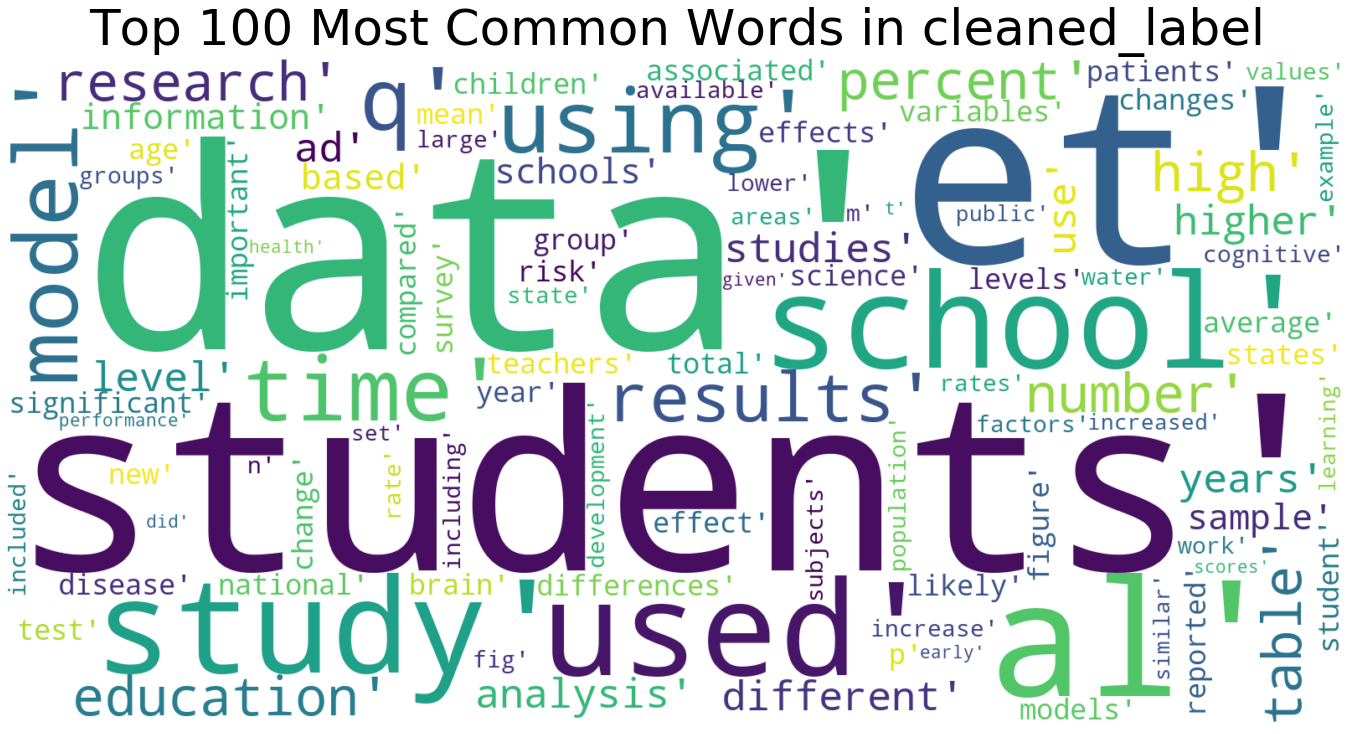

In [29]:
from nltk.probability import FreqDist
from wordcloud import WordCloud

mostcommon = FreqDist(list_of_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=ENGLISH_STOP_WORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()


In [33]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
list_of_words_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(' '.join(list_of_words))]

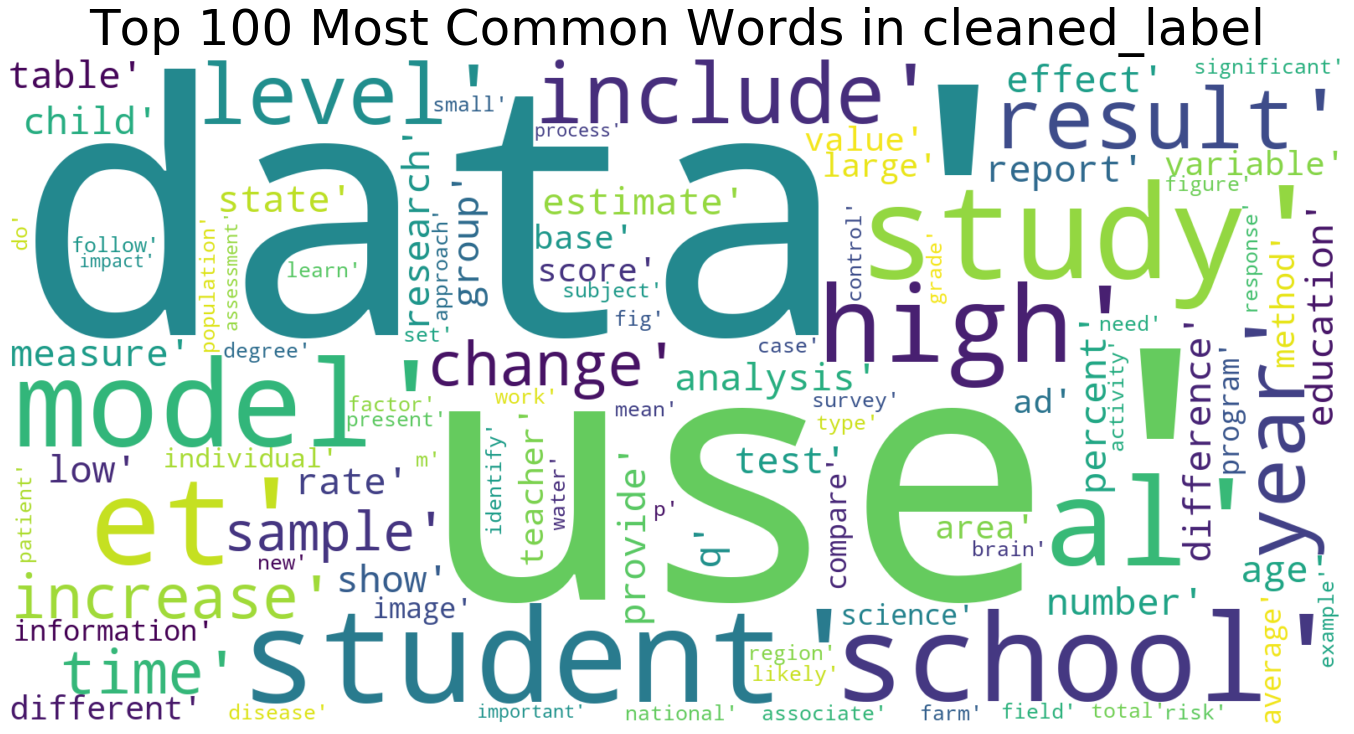

In [35]:
mostcommon_lem = FreqDist(list_of_words_lem).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', 
                      stopwords=ENGLISH_STOP_WORDS).generate(str(mostcommon_lem))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()


In [36]:
df_list_of_all_words = pd.DataFrame({'words':list_of_words_lem})

In [38]:
df_list_of_all_words.to_csv('all_words_lemmatized.csv')

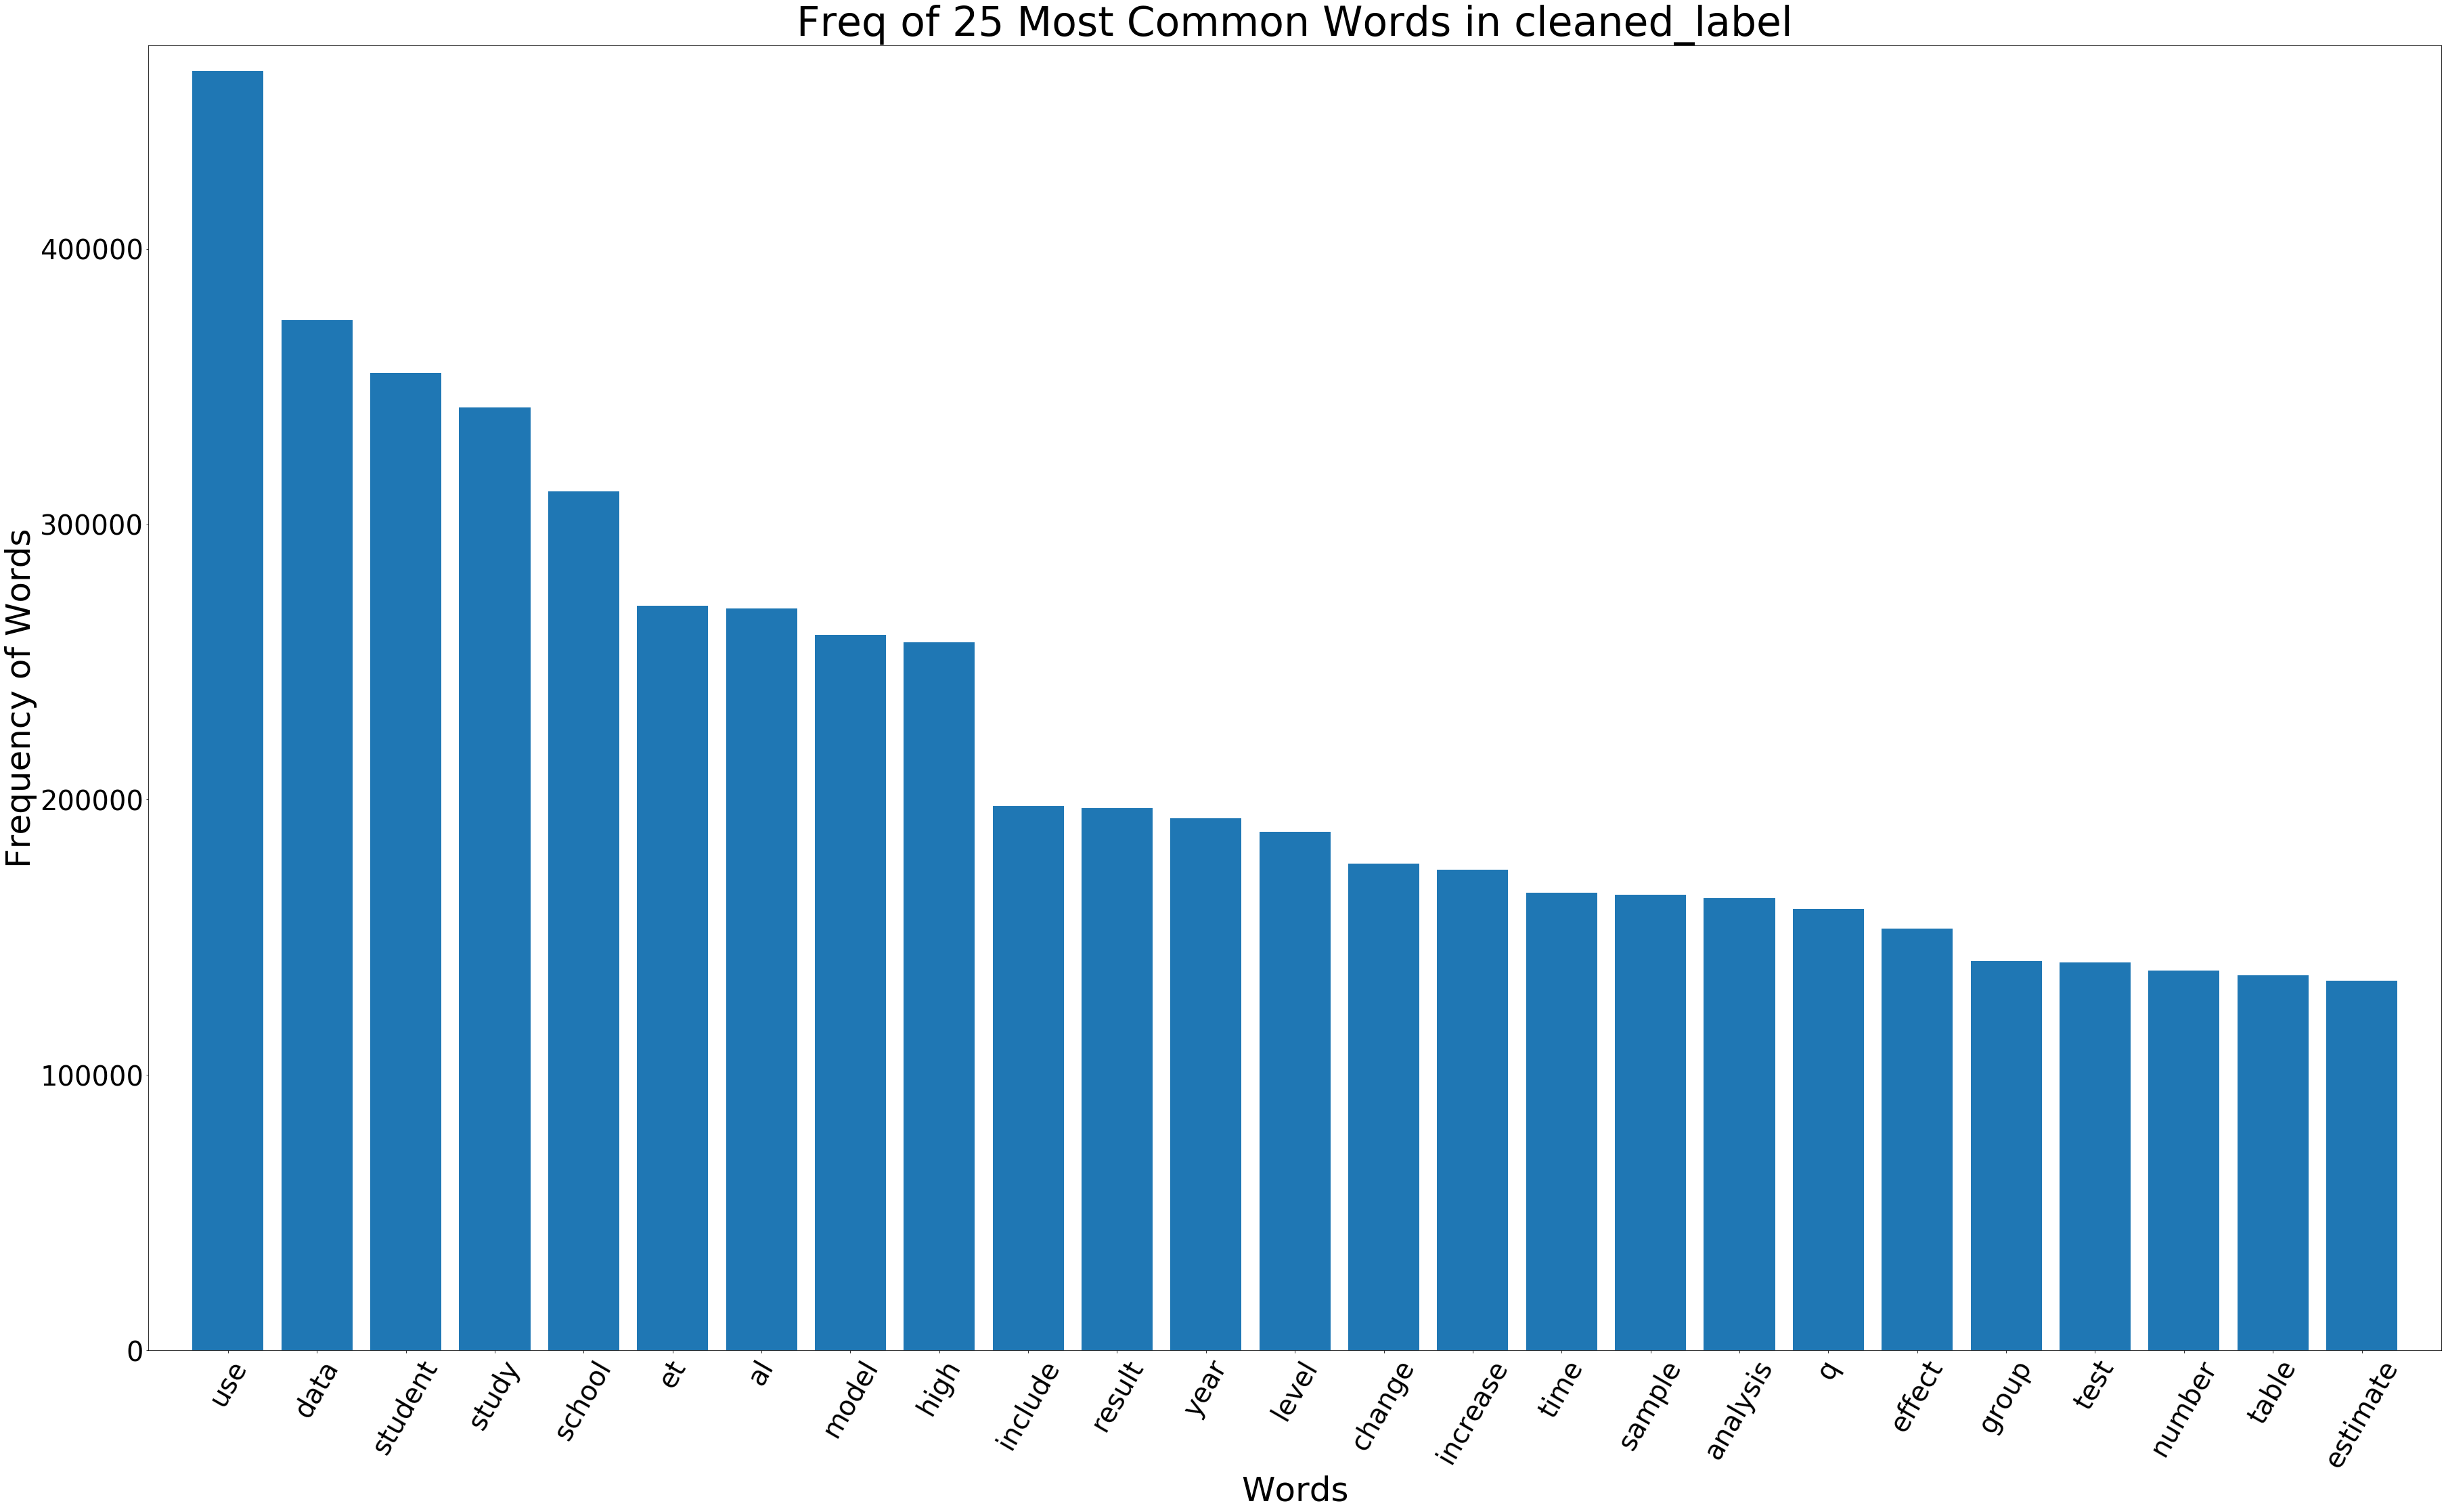

In [39]:
mostcommon_small = FreqDist(list_of_words_lem).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()
